# Import the required libraries

In [1]:
import pandas as pd
import numpy as np
from PIL import Image

import tensorflow as tf
#modelling
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import os

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pickle




# Preprocessing the image data

In [2]:
#taking the train validation ratio as 4:1

In [3]:
batch_size=32
img_height=256
img_width=256


train_ds = tf.keras.utils.image_dataset_from_directory(
  "../data/asl-alphabet/asl_alphabet_train/asl_alphabet_train/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  "../data/asl-alphabet/asl_alphabet_train/asl_alphabet_train/",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [5]:
class_names = train_ds.class_names
print("Class names:",class_names)
print("Total classes:",len(class_names))

Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Total classes: 29


In [6]:
#random samples of images from the train data

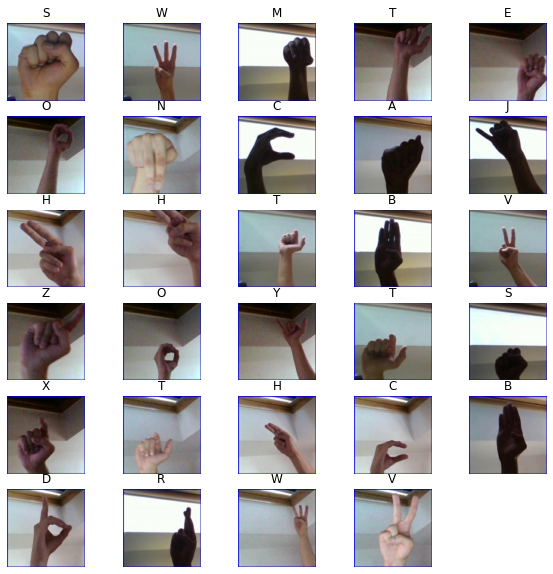

In [7]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(29):
        ax = plt.subplot(6,5 , i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Modelling and training

In [24]:

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(29,activation='softmax')
])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)       

In [27]:
from keras.callbacks import ModelCheckpoint

# Define the filepath to save the best model
filepath = 'best_model.h5'

# Create the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)



model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [28]:
model.fit(train_ds, batch_size=32,validation_batch_size=32, validation_data=test_ds,epochs=3, callbacks=[checkpoint])

Epoch 1/3
2175/2175 [==============================] - 161s 74ms/step - loss: 0.8831 - accuracy: 0.7263 - val_loss: 0.1863 - val_accuracy: 0.9391

Epoch 00001: val_accuracy improved from -inf to 0.93908, saving model to best_model.h5
Epoch 2/3
2175/2175 [==============================] - 127s 58ms/step - loss: 0.1223 - accuracy: 0.9595 - val_loss: 0.1255 - val_accuracy: 0.9571

Epoch 00002: val_accuracy improved from 0.93908 to 0.95707, saving model to best_model.h5
Epoch 3/3
2175/2175 [==============================] - 133s 61ms/step - loss: 0.0678 - accuracy: 0.9776 - val_loss: 0.0885 - val_accuracy: 0.9699

Epoch 00003: val_accuracy improved from 0.95707 to 0.96994, saving model to best_model.h5


# Prediction on the test data

In [12]:
# Get the list of all files and directories
path = "../data/asl-alphabet/asl_alphabet_test/asl_alphabet_test/"
dir_list = os.listdir(path)
 
print(dir_list)

['A_test.jpg', 'E_test.jpg', 'L_test.jpg', 'N_test.jpg', 'S_test.jpg', 'D_test.jpg', 'G_test.jpg', 'I_test.jpg', 'W_test.jpg', 'M_test.jpg', 'nothing_test.jpg', 'X_test.jpg', 'H_test.jpg', 'Q_test.jpg', 'C_test.jpg', 'T_test.jpg', 'P_test.jpg', 'V_test.jpg', 'Y_test.jpg', 'U_test.jpg', 'space_test.jpg', 'O_test.jpg', 'B_test.jpg', 'R_test.jpg', 'F_test.jpg', 'Z_test.jpg', 'J_test.jpg', 'K_test.jpg']


In [19]:

actual=[]
pred=[]
for i in dir_list:
    actual.append(i.split('_')[0])
    img = Image.open('../data/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'+i)
    img = img.resize((256,256))  # Resize the image to match your model's input size
    img_array = np.array(img)
    img = np.expand_dims(img, axis = 0)
    result = model.predict(img)
    pred.append(class_names[np.argmax(result)])

In [21]:
print("Test accuracy=",accuracy_score(pred,actual))
print("Classification report:\n",classification_report(pred,actual))


Test accuracy= 0.9285714285714286
Classification report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00         1
           N       1.00      1.00      1.00         1
           O       1.00      1.00      1.00         1
           P       1.00      1.00      1.00         1
           Q       1.00

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
def save_variable(variable, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(variable, file)


In [33]:
save_variable(class_names,'mapping.pkl')